# Classifying Fashion-MNIST


<img src='assets/fashion-mnist-sprite.png' width=500px>

## Import Resources

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

In [3]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [4]:
print('Using:')
print('\t\u2022 TensorFlow version:', tf.__version__)
print('\t\u2022 tf.keras version:', tf.keras.__version__)
print('\t\u2022 Running on GPU' if tf.test.is_gpu_available() else '\t\u2022 GPU device not found. Running on CPU')

Using:
	• TensorFlow version: 2.9.1
	• tf.keras version: 2.9.0
	• GPU device not found. Running on CPU


## Load the Dataset

In [6]:
train_split = 60
test_val_split = 20

dataset, dataset_info = tfds.load('fashion_mnist', split=['train[:60%]','train[60%:80%]','train[80%:]'], as_supervised=True, with_info=True)

training_set, validation_set, test_set = dataset

Dataset fashion_mnist downloaded and prepared to C:\Users\LENOVO\tensorflow_datasets\fashion_mnist\3.0.1. Subsequent calls will reuse this data.


## Explore the Dataset

In [7]:
# Display dataset
dataset

[<PrefetchDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>]

In [8]:
# Display dataset_info
dataset_info

tfds.core.DatasetInfo(
    name='fashion_mnist',
    full_name='fashion_mnist/3.0.1',
    description="""
    Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.
    """,
    homepage='https://github.com/zalandoresearch/fashion-mnist',
    data_path='C:\\Users\\LENOVO\\tensorflow_datasets\\fashion_mnist\\3.0.1',
    file_format=tfrecord,
    download_size=29.45 MiB,
    dataset_size=36.42 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{DBLP:journals/corr/abs-1708-07

In [9]:
total_examples = dataset_info.splits['train'].num_examples + dataset_info.splits['test'].num_examples

num_training_examples = (total_examples * train_split) // 100
num_validation_examples = (total_examples * test_val_split) // 100
num_test_examples = num_validation_examples

print('There are {:,} images in the training set'.format(num_training_examples))
print('There are {:,} images in the validation set'.format(num_validation_examples))
print('There are {:,} images in the test set'.format(num_test_examples))

There are 42,000 images in the training set
There are 14,000 images in the validation set
There are 14,000 images in the test set


The images in this dataset are 28 $\times$ 28 arrays, with pixel values in the range `[0, 255]`. The *labels* are an array of integers, in the range `[0, 9]`. These correspond to the *class* of clothing the image represents:

<table>
  <tr>
    <th>Label</th>
    <th>Class</th> 
  </tr>
  <tr>
    <td>0</td>
    <td>T-shirt/top</td> 
  </tr>
  <tr>
    <td>1</td>
    <td>Trouser</td> 
  </tr>
    <tr>
    <td>2</td>
    <td>Pullover</td> 
  </tr>
    <tr>
    <td>3</td>
    <td>Dress</td> 
  </tr>
    <tr>
    <td>4</td>
    <td>Coat</td> 
  </tr>
    <tr>
    <td>5</td>
    <td>Sandal</td> 
  </tr>
    <tr>
    <td>6</td>
    <td>Shirt</td> 
  </tr>
    <tr>
    <td>7</td>
    <td>Sneaker</td> 
  </tr>
    <tr>
    <td>8</td>
    <td>Bag</td> 
  </tr>
    <tr>
    <td>9</td>
    <td>Ankle boot</td> 
  </tr>
</table>

Each image is mapped to a single label. Since the *class names* are not included with the dataset, we create them here to use later when plotting the images:

In [10]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal',      'Shirt',   'Sneaker',  'Bag',   'Ankle boot']

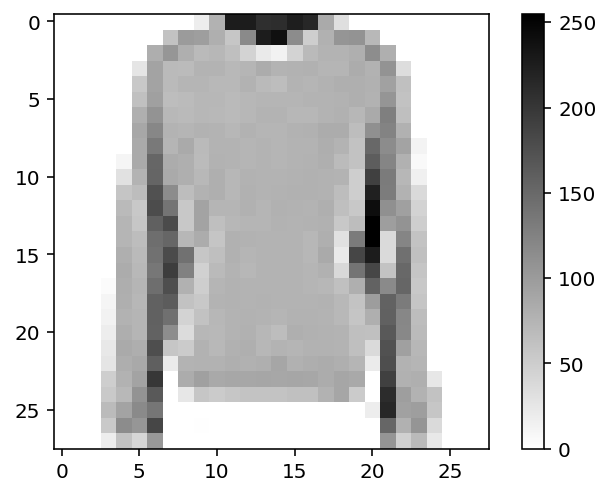

The label of this image is: 2
The class name of this image is: Pullover


In [11]:
for image, label in training_set.take(1):
    image = image.numpy().squeeze()
    label = label.numpy()

plt.imshow(image, cmap= plt.cm.binary)
plt.colorbar()
plt.show()

print('The label of this image is:', label)
print('The class name of this image is:', class_names[label])

## Create Pipeline

In [12]:
def normalize(image, label):
    image = tf.cast(image, tf.float32)
    image /= 255
    return image, label

batch_size = 64

training_batches = training_set.cache().shuffle(num_training_examples//4).batch(batch_size).map(normalize).prefetch(1)
validation_batches = validation_set.cache().batch(batch_size).map(normalize).prefetch(1)
testing_batches = test_set.cache().batch(batch_size).map(normalize).prefetch(1)

## Build the Model

In [13]:
model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(28,28,1)),
        tf.keras.layers.Dense(256, activation = 'relu'),
        tf.keras.layers.Dense(128, activation = 'relu'),
        tf.keras.layers.Dense(64, activation = 'relu'),
        tf.keras.layers.Dense(10, activation = 'softmax')
])

## Train the Model

In [14]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

EPOCHS = 30

history = model.fit(training_batches,
                    epochs = EPOCHS,
                    validation_data=validation_batches)

Epoch 1/30
563/563 [==============================] - 4s 6ms/step - loss: 0.5491 - accuracy: 0.8075 - val_loss: 0.4463 - val_accuracy: 0.8406
Epoch 2/30
563/563 [==============================] - 2s 4ms/step - loss: 0.3957 - accuracy: 0.8559 - val_loss: 0.3826 - val_accuracy: 0.8614
Epoch 3/30
563/563 [==============================] - 2s 4ms/step - loss: 0.3508 - accuracy: 0.8718 - val_loss: 0.3425 - val_accuracy: 0.8752
Epoch 4/30
563/563 [==============================] - 2s 4ms/step - loss: 0.3267 - accuracy: 0.8792 - val_loss: 0.3599 - val_accuracy: 0.8749
Epoch 5/30
563/563 [==============================] - 2s 4ms/step - loss: 0.3052 - accuracy: 0.8871 - val_loss: 0.3421 - val_accuracy: 0.8763
Epoch 6/30
563/563 [==============================] - 2s 4ms/step - loss: 0.2877 - accuracy: 0.8935 - val_loss: 0.3527 - val_accuracy: 0.8728
Epoch 7/30
563/563 [==============================] - 2s 4ms/step - loss: 0.2794 - accuracy: 0.8964 - val_loss: 0.3206 - val_accuracy: 0.8875
Epoch 

## Evaluate Loss and Accuracy on the Test Set

In [15]:
loss, accuracy = model.evaluate(testing_batches)

print('\nLoss on the TEST Set: {:,.3f}'.format(loss))
print('Accuracy on the TEST Set: {:.3%}'.format(accuracy))

188/188 [==============================] - 1s 4ms/step - loss: 0.4134 - accuracy: 0.8955

Loss on the TEST Set: 0.413
Accuracy on the TEST Set: 89.550%


## Loss and Validation Plots

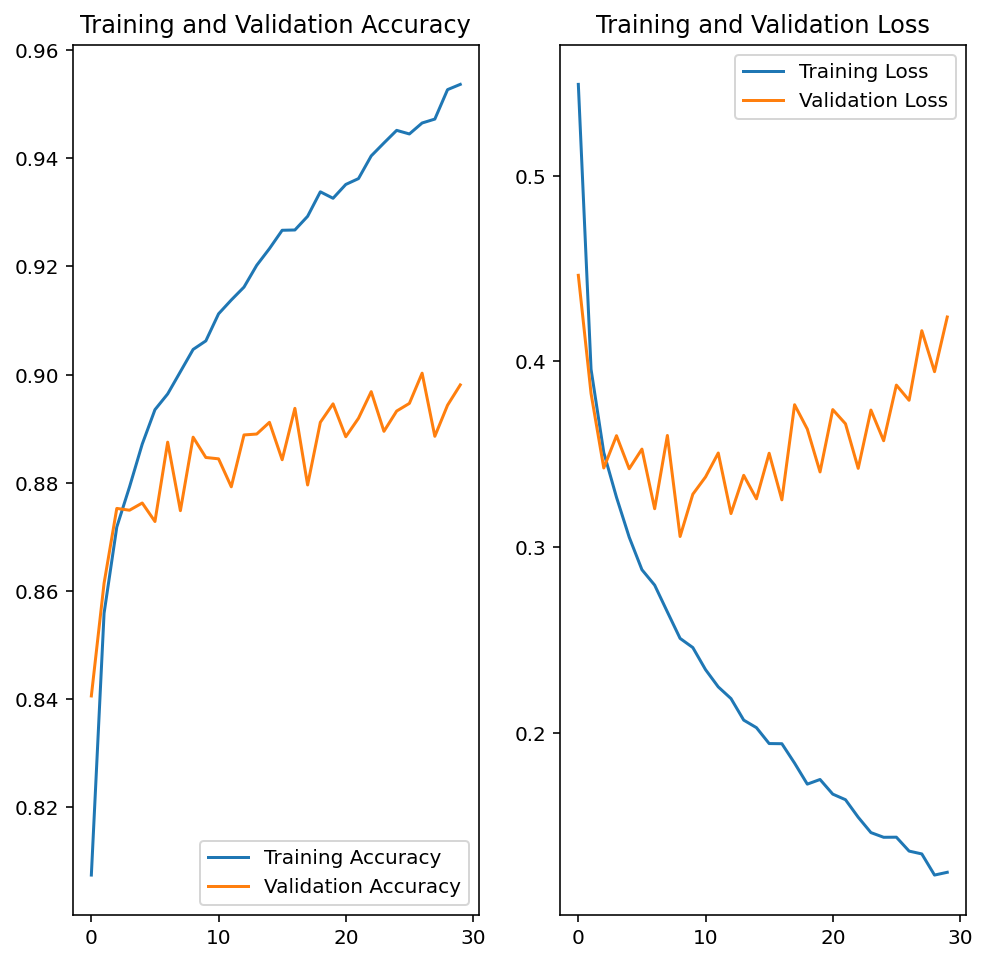

In [16]:
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs_range=range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Early Stopping

In [17]:
model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(28,28,1)),
        tf.keras.layers.Dense(256, activation = 'relu'),
        tf.keras.layers.Dense(128, activation = 'relu'),
        tf.keras.layers.Dense(64, activation = 'relu'),
        tf.keras.layers.Dense(10, activation = 'softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Stop training when there is no improvement in the validation loss for 5 consecutive epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(training_batches,
                    epochs = 100,
                    validation_data=validation_batches,
                    callbacks=[early_stopping])

Epoch 1/100
563/563 [==============================] - 3s 4ms/step - loss: 0.5489 - accuracy: 0.8048 - val_loss: 0.4292 - val_accuracy: 0.8393
Epoch 2/100
563/563 [==============================] - 2s 4ms/step - loss: 0.3916 - accuracy: 0.8575 - val_loss: 0.3855 - val_accuracy: 0.8584
Epoch 3/100
563/563 [==============================] - 2s 4ms/step - loss: 0.3534 - accuracy: 0.8706 - val_loss: 0.3741 - val_accuracy: 0.8683
Epoch 4/100
563/563 [==============================] - 3s 5ms/step - loss: 0.3265 - accuracy: 0.8806 - val_loss: 0.3523 - val_accuracy: 0.8729
Epoch 5/100
563/563 [==============================] - 2s 4ms/step - loss: 0.3066 - accuracy: 0.8859 - val_loss: 0.3425 - val_accuracy: 0.8780
Epoch 6/100
563/563 [==============================] - 2s 4ms/step - loss: 0.2892 - accuracy: 0.8907 - val_loss: 0.3599 - val_accuracy: 0.8725
Epoch 7/100
563/563 [==============================] - 2s 4ms/step - loss: 0.2758 - accuracy: 0.8975 - val_loss: 0.3409 - val_accuracy: 0.8748

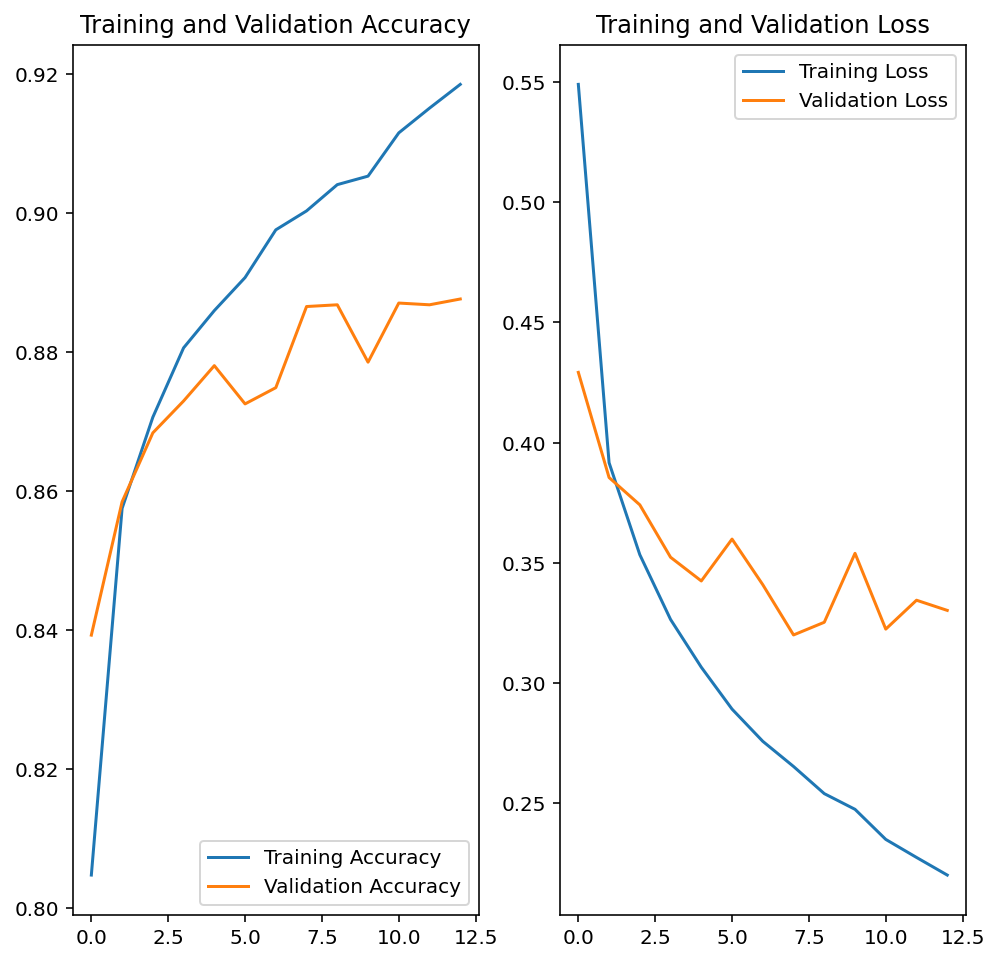

In [18]:
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs_range=range(len(training_accuracy))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Dropout

In [19]:
model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(28,28,1)),
        tf.keras.layers.Dense(256, activation = 'relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(128, activation = 'relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(64, activation = 'relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(10, activation = 'softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


history = model.fit(training_batches,
                    epochs = 30,
                    validation_data=validation_batches)

Epoch 1/30
563/563 [==============================] - 3s 5ms/step - loss: 0.6822 - accuracy: 0.7566 - val_loss: 0.4395 - val_accuracy: 0.8422
Epoch 2/30
563/563 [==============================] - 3s 5ms/step - loss: 0.4745 - accuracy: 0.8324 - val_loss: 0.4032 - val_accuracy: 0.8525
Epoch 3/30
563/563 [==============================] - 3s 5ms/step - loss: 0.4240 - accuracy: 0.8461 - val_loss: 0.3955 - val_accuracy: 0.8533
Epoch 4/30
563/563 [==============================] - 3s 5ms/step - loss: 0.4002 - accuracy: 0.8557 - val_loss: 0.3587 - val_accuracy: 0.8688
Epoch 5/30
563/563 [==============================] - 3s 5ms/step - loss: 0.3741 - accuracy: 0.8650 - val_loss: 0.3556 - val_accuracy: 0.8707
Epoch 6/30
563/563 [==============================] - 3s 5ms/step - loss: 0.3618 - accuracy: 0.8681 - val_loss: 0.3711 - val_accuracy: 0.8612
Epoch 7/30
563/563 [==============================] - 3s 5ms/step - loss: 0.3498 - accuracy: 0.8711 - val_loss: 0.3414 - val_accuracy: 0.8777
Epoch 

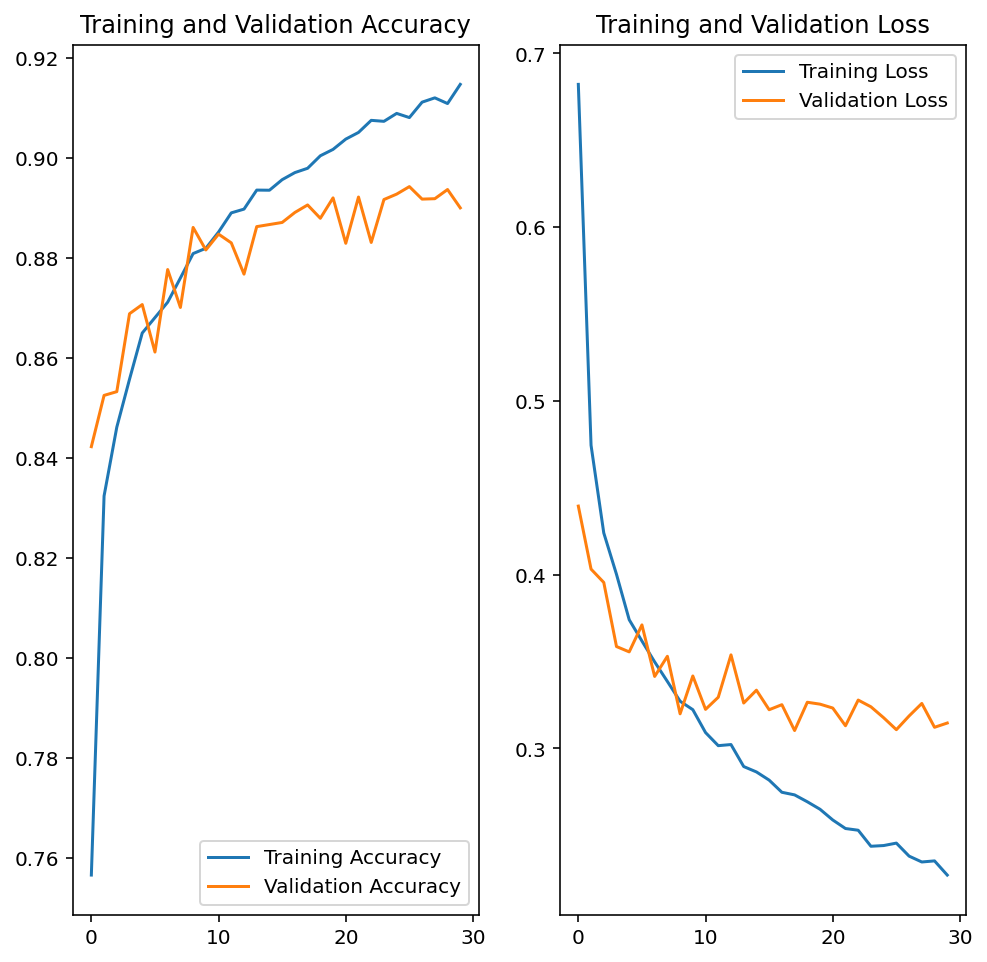

In [20]:
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs_range=range(len(training_accuracy))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Inference

2/2 [==============================] - 0s 3ms/step


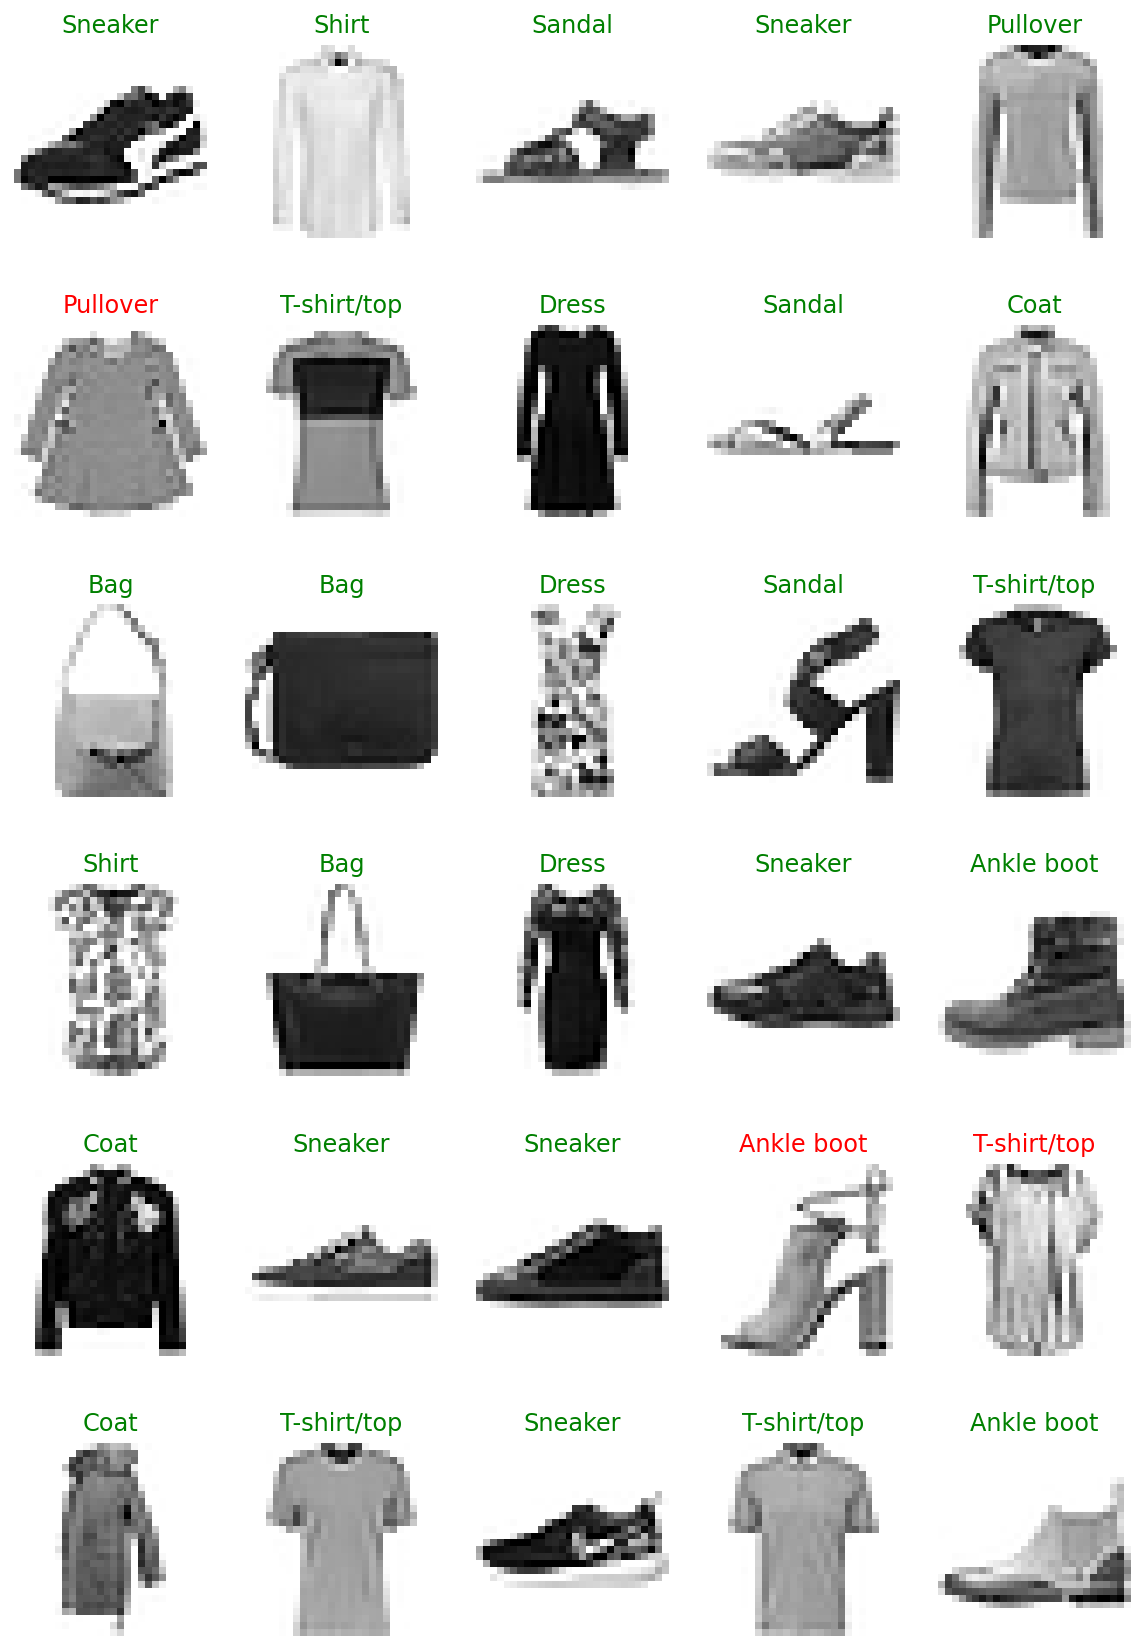

In [21]:
for image_batch, label_batch in testing_batches.take(1):
    ps = model.predict(image_batch)
    images = image_batch.numpy().squeeze()
    labels = label_batch.numpy()


plt.figure(figsize=(10,15))

for n in range(30):
    plt.subplot(6,5,n+1)
    plt.imshow(images[n], cmap = plt.cm.binary)
    color = 'green' if np.argmax(ps[n]) == labels[n] else 'red'
    plt.title(class_names[np.argmax(ps[n])], color=color)
    plt.axis('off')